In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.2 MB/s 
     |████████████████████████████████| 636 kB 73.9 MB/s 
     |████████████████████████████████| 3.3 MB 24.9 MB/s 
     |████████████████████████████████| 895 kB 79.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pickle 
from transformers import TFBertModel
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

with open('/content/drive/MyDrive/news20_train_data.pkl', 'rb') as f:
  x_train_ids, x_train_msk, x_train_typ, x_test_ids, x_test_msk, x_test_typ, y_train, y_test=pickle.load(f)

In [4]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased', cache_dir='bert_eng_ckpt')
bert_model.summary()

bert_model.trainable = False
bert_model.summary() 

MAX_LEN = 20
n_topic = len(y_train)

x_input_ids = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_msk = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_typ = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)

output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])
y_output = Dense(n_topic, activation = 'softmax')(output_bert[1])
model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

output_bert

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________
Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function

TFBaseModelOutputWithPooling([('last_hidden_state',
                               <KerasTensor: shape=(None, 20, 768) dtype=float32 (created by layer 'tf_bert_model')>),
                              ('pooler_output',
                               <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>)])

In [5]:
x_train = [x_train_ids, x_train_msk, x_train_typ]
x_test = [x_test_ids, x_test_msk, x_test_typ]
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, batch_size=256)

Epoch 1/100
27/27 [==============================] - 21s 401ms/step - loss: 3.2077 - val_loss: 2.6923
Epoch 2/100
27/27 [==============================] - 9s 347ms/step - loss: 2.5795 - val_loss: 2.4452
Epoch 3/100
27/27 [==============================] - 9s 348ms/step - loss: 2.3330 - val_loss: 2.2564
Epoch 4/100
27/27 [==============================] - 9s 350ms/step - loss: 2.2184 - val_loss: 2.1502
Epoch 5/100
27/27 [==============================] - 9s 353ms/step - loss: 2.1262 - val_loss: 2.0057
Epoch 6/100
27/27 [==============================] - 10s 354ms/step - loss: 2.0778 - val_loss: 1.9727
Epoch 7/100
27/27 [==============================] - 10s 357ms/step - loss: 1.9813 - val_loss: 1.8243
Epoch 8/100
27/27 [==============================] - 10s 359ms/step - loss: 1.8995 - val_loss: 1.8550
Epoch 9/100
27/27 [==============================] - 10s 378ms/step - loss: 1.8607 - val_loss: 1.7621
Epoch 10/100
27/27 [==============================] - 10s 369ms/step - loss: 1.8422 - 

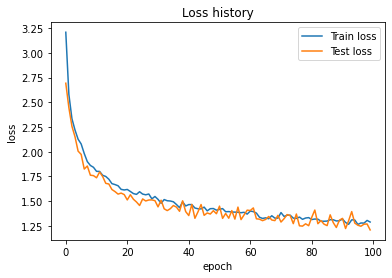


Accuracy = 62.76 %


In [7]:
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))